# Single Cell apoptosis

#### As decribed in Monier et al. 2015

In [1]:
import pandas as pd
import numpy as np
import json
import matplotlib.pylab as plt
try:
    import seaborn as sns
except ImportError:
    print('Seaborn not found')
%matplotlib inline
from IPython.display import display


from tyssue import Sheet, SheetGeometry as geom
from tyssue import config

from tyssue.dynamics import SheetModel as basemodel

from tyssue.dynamics.apoptosis_model import SheetApoptosisModel as model
from tyssue.solvers.sheet_vertex_solver import Solver as solver

from tyssue.draw.plt_draw import sheet_view
from tyssue.io.hdf5 import load_datasets

### Loading the datasets and specifications

Here it is a cylindrical hexagonal mesh.

In [2]:
# h5store = 'before_apoptosis.hf5'
h5store = '../data/hf5/small_hexagonal.hf5'

datasets = load_datasets(h5store,
                         data_names=['face', 'vert', 'edge'])
specs = config.geometry.cylindrical_sheet()
sheet = Sheet('emin', datasets, specs)
geom.update_all(sheet)

nondim_specs = config.dynamics.quasistatic_sheet_spec()
dim_model_specs = model.dimentionalize(nondim_specs)
sheet.update_specs(dim_model_specs)


live_edges = sheet.upcast_face(sheet.face_df.is_alive)
dead_src = set(sheet.edge_df[live_edges==0].srce)

### Boundary conditions
sheet.vert_df.is_active = 1
sheet.vert_df.loc[dead_src, 'is_active'] = 0

### Energy minimization with the quasi-static model

You can change the minimization settings bellow:
* `'ftol'`: minimum relative change in the total energy to stop minimisation iterations    
* `'gtol'`: minimum relative change in the force to stop minimisation iterations
If those values are higher, the convergence will be faster but less precise.

See `scipy.optimize` for more options.

In [3]:
min_settings = {
    'minimize': {
        'options': {
            'ftol': 1e-6,    
            'gtol': 1e-5},
        }
    }

res = solver.find_energy_min(sheet, geom, model, **min_settings)
print(res['success'])

True


### Definition of a custom visualisation function

You can change parts of this function to fit your needs. See `tyssue.draw.plt_draw.sheet_view` for details.

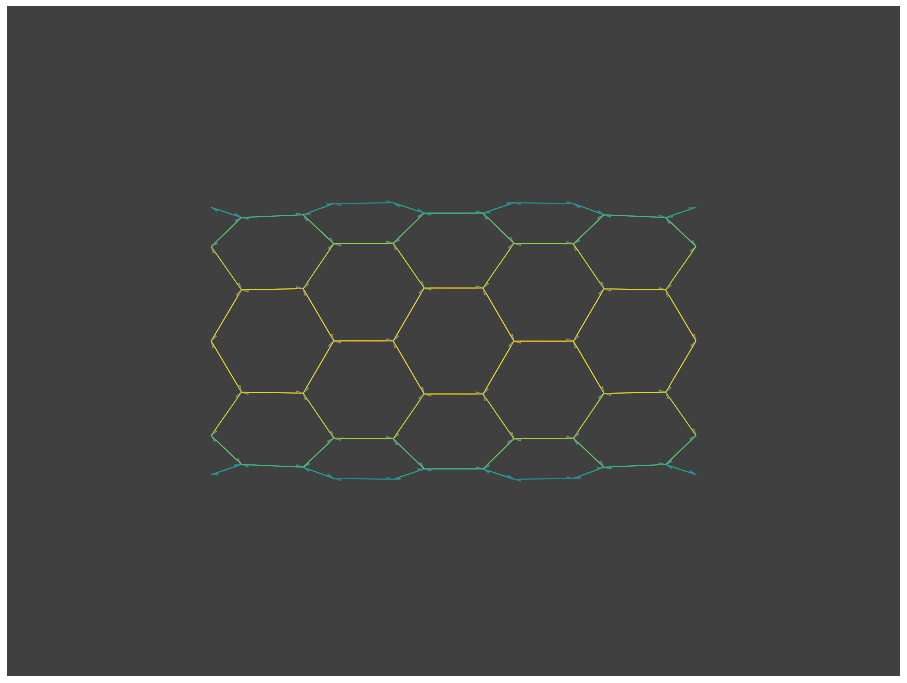

In [4]:
def leg_joint_view(sheet, coords=['z', 'x', 'y']):
    """
    Displays a 2D projection of the sheet, in the plane defined
    by the 2 first coordinates in `coords`. The third coordinate, perpendicular
    to the projection, is color-coded.
    """
    x, y, z = coords
    datasets = {}
    
    # ## Sort the elements along the depth axis 
    datasets['face'] = sheet.face_df.sort_values(z)
    datasets['vert'] = sheet.vert_df.sort_values(z)
    edge_z = 0.5 * (sheet.upcast_srce(sheet.vert_df[z]) +
                    sheet.upcast_trgt(sheet.vert_df[z]))
    datasets['edge'] = sheet.edge_df.copy()
    datasets['edge'][z] = edge_z
    datasets['edge'] = datasets['edge'].sort_values(z)
    
    tmp_sheet = Sheet('tmp', datasets,
                      sheet.specs)
    tmp_sheet.reset_index()
    cmap = plt.cm.get_cmap('viridis')
    
    e_depth = (tmp_sheet.edge_df[z] -
               tmp_sheet.edge_df[z].min()) / tmp_sheet.edge_df[z].ptp()
    depth_cmap = cmap(e_depth)
    draw_specs = {'vert': {'visible': False},
                  'edge': {'color': depth_cmap}}
    
    fig, ax = sheet_view(tmp_sheet, coords[:2], **draw_specs)
    # ## set limits
    ax.set_xlim(-20, 20)
    ax.set_ylim(-15, 15)
    ax.set_axis_bgcolor('#404040')
    ax.set_xticks([])
    ax.set_yticks([])
    fig.set_size_inches((16, 19))
    return fig, ax

fig, ax = leg_joint_view(sheet)


## Choose an apoptotic cell

In [8]:
apoptotic_cell = 16
print('Apoptotic cell position:\n{}'.format(sheet.face_df.loc[apoptotic_cell, sheet.coords]))
apoptotic_edges = sheet.edge_df[sheet.edge_df['face'] == apoptotic_cell]
apoptotic_verts = apoptotic_edges['srce'].values
print("Indices of the apoptotic vertices: {}".format(apoptotic_verts))

Apoptotic cell position:
x   -2.238969
y    5.413359
z   -4.033463
Name: 16, dtype: float64
Indices of the apoptotic vertices: [28 39 29 38 40 41]


## Apoptosis behavior

In [9]:
from tyssue.behaviors.sheet_events import SheetEvents
from tyssue.behaviors.behaviors import apoptosis_time_table
events = SheetEvents(sheet, model, geom).events

print('Defined events (single time step):')
print('\n'.join([k for k in events]))


Defined events (single time step):
type3
grow
type1_at_shorter
shrink
ab_pull
contract
divide


### Programming of the apoptotic sequence
The following parameters can be modified:

* `'shrink_steps`: The number of shrinking steps in the sequence ,
* `'rad_tension'`: Value of the terminal apico-basal tension, in units of $\Lambda$,
* `'contractile_increase'`: Value of the terminal increase in contractility in the neighboring cells, units of $\Gamma$,
* `'contract_span'`: Span of increase in contractility in the neighbor cells 


In [8]:
sheet.settings['apoptosis'] = {
    'shrink_steps': 20,
    'rad_tension': 1,
    'contractile_increase': 2,
    'contract_span': 2
    }

times, time_table = apoptosis_time_table(sheet,
                                         apoptotic_cell,
                                         events,
                                         start_t=0)

In [10]:
for t in times:
    face_events = time_table.loc[t]
    for face, evts in face_events.iterrows():
        for event_name, event_arg in evts.dropna().items():
            events[event_name](face, event_arg)

    res = solver.find_energy_min(sheet, geom, model, **min_settings)
    fig, ax = leg_joint_view(sheet)
    plt.savefig('../data/png/single_apopto_{:03d}.png'.format(t))
    plt.close(fig)

### View the results as an animated gif

providing you have ImageMagick on your system:

In [11]:
%%bash
convert ../data/png/single_apopto_*.png ../data/gif/single_apopto.gif

![The result of our simulation](../data/png/single_apopto_023.png)